Data is at ../GCNS_var.fits

Data is taken from https://gea.esac.esa.int/archive/ by joining the catalogue of variable stars from Gaia DR3 and the Gaia Catalogue of Nearby Stars (GCNS) from Gaia EDR3 via the query
``` sql
SELECT gcns.*
FROM gaiadr3.vari_summary AS var
JOIN external.gaiaedr3_gcns_main_1 AS gcns ON var.source_id=gcns.source_id
```

### Import Packages

In [150]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d

import cubehelix

In [4]:
import matplotlib
from mpl_toolkits.mplot3d import axes3d   
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

#### Color Maps

In [5]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

#### Create SkyCoord Object for SN1987A with RA, Dec, Distance

In [6]:
# Properties of SN1987A
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [7]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.2697417)>
51400.0 pc


#### Read in GCNS Data and Turn Into SkyCoord Objects

In [12]:
GCNS_file = '../GCNS_var.fits'
GCNS = Table.read(GCNS_file, format='fits')

In [28]:
c1 = SkyCoord(ra = GCNS['ra'],
              dec = GCNS['dec'],
              distance = GCNS['dist_50'],
              frame = 'icrs')
# in degrees, degrees, kpc

In [22]:
c1[0]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (321.33291268, 39.13638031, 0.08741934)>

In [23]:
len(GCNS)

26787

#### Time Since Event Was Observed

In [24]:
t1 = Time.now()
dt = t1-t0

dt.to('year')

<Quantity 35.30989239 yr>

#### Ellipsoid Geometry

In [25]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center (half the distance from Earth to SN1987A, the two foci)
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # semi-major axis of ellipse
# first term is the distance along the major axis beyond Earth -- it is half the distance light would travel in the time since the event was observed
     
print(a-c) # should be half the value of dt above, but in lyr

17.654946192516945 lyr


#### GCNS Star Geometric Properties

In [30]:
d1 = (GCNS['dist_50']) # dist to GCNS stars (in kpc)

d2 = c1.separation_3d(c0) # dist from all GCNS stars to SN 1987A

In [37]:
# Q1. Has the star seen SN1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES
# left side is the distance from the star to SN 1987A
# right side is the distance from SN 1987A to Earth plus the extra distance light has travelled since it was observed


# Q2. Is it within the SETI Ellipsoid?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES
# left side is distance from SN 1987A to star plus distance from star to Earth
# right side is the major axis (the sum of the two focal point distances for all points on an ellipse/ellipsoid is equal to the major axis length)

# Q3. Is it within some toleratnce of being ON the ellipse?
# Either a range of distance of time
tol = 0.1 # lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol
# check if sum of focal point distances minus the major axis diameter is within the interval (-tol, tol)

In [39]:
print('Total number of variable stars in GCNS:', len(d1))
print('Number of variable stars that have seen SN1987A:', sum(SNYES))
print('Number of variable stars that have not seen SN1987A:', sum(SNNO))
print('Number of variable stars within SETI Ellipsoid:', sum(EYES))
print('Number of variable stars within ' + str( tol ) + ' lyr of ellipsoid:', sum(OYES))

Total number of variable stars in GCNS: 26787
Number of variable stars that have seen SN1987A: 14822
Number of variable stars that have not seen SN1987A: 11965
Number of variable stars within SETI Ellipsoid: 1896
Number of variable stars within 0.1 lyr of ellipsoid: 14


In [40]:
print('Fraction of variable GCNS stars that have seen SN1987A:', sum(SNYES) / len(d1))
print('Fraction of variable GCNS stars that have not seen SN1987A:', sum(SNNO) / len(d1))
print('Fraction of variable GCNS stars within SETI Ellipsoid:', sum(EYES) / len(d1))

Fraction of variable GCNS stars that have seen SN1987A: 0.5533281069175346
Fraction of variable GCNS stars that have not seen SN1987A: 0.44667189308246535
Fraction of variable GCNS stars within SETI Ellipsoid: 0.07078060253107851


These are similar fractions to those from all GCNS stars (i.e. not just variable stars)

## Plotting

Text(0.5, 0, 'Z (pc)')

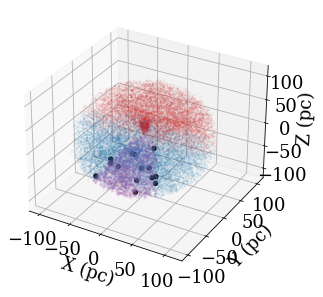

In [42]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(GCNS['xcoord_50'][SNNO], GCNS['ycoord_50'][SNNO], GCNS['zcoord_50'][SNNO], c='C3', s=1, alpha=0.05, rasterized=True)
ax.scatter(GCNS['xcoord_50'][SNYES], GCNS['ycoord_50'][SNYES], GCNS['zcoord_50'][SNYES], c='C0', s=1, alpha=0.05, rasterized=True)
ax.scatter(GCNS['xcoord_50'][EYES], GCNS['ycoord_50'][EYES], GCNS['zcoord_50'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(GCNS['xcoord_50'][OYES], GCNS['ycoord_50'][OYES], GCNS['zcoord_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

Text(0, 0.5, 'Z (pc)')

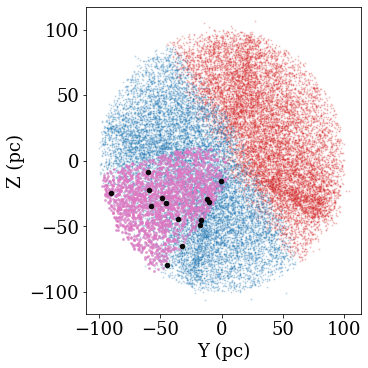

In [44]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()

ax.scatter(GCNS['ycoord_50'][SNNO], GCNS['zcoord_50'][SNNO], c='C3', s=1, alpha=0.2, rasterized=True)
ax.scatter(GCNS['ycoord_50'][SNYES], GCNS['zcoord_50'][SNYES], c='C0', s=1, alpha=0.2, rasterized=True)
ax.scatter(GCNS['ycoord_50'][EYES], GCNS['zcoord_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
ax.scatter(GCNS['ycoord_50'][OYES], GCNS['zcoord_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

ax.set_xlabel('Y (pc)')
ax.set_ylabel('Z (pc)')

## Another way of looking at it in terms of time

In [82]:
# The ellipsoid is d2 + r = 2c + time (focal point distances equals major axis)
# So we can rewrite this as time = d2 + r - 2c

etime = d2.to('lyr') + d1.to('lyr') - (2*c)

x10 = np.abs(GCNS['xcoord_50']) < 10 # 'slice' through GCNS, with galactocentric |X| < 10 pc

In [83]:
sum(x10)

4467

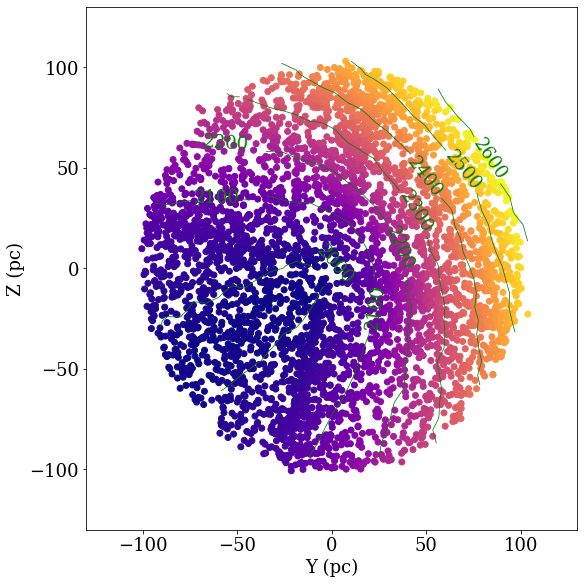

In [115]:
H, xe, ye, bn = binned_statistic_2d(GCNS['ycoord_50'][x10], GCNS['zcoord_50'][x10],
                                    values = etime[x10].value + t0.decimalyear, 
                                    statistic='mean', bins=30) # mean binning for contours
XX, YY = np.meshgrid(xe, ye)


plt.figure(figsize=(8,8), constrained_layout=True)
plt.scatter(GCNS['ycoord_50'][x10], GCNS['zcoord_50'][x10],
            c=(etime[x10].value + t0.decimalyear), cmap=plt.cm.plasma, rasterized=True)
# contour (c) is the time (d2 + r - 2c) plus the time when the event was observed on Earth (1987)


cs = plt.contour(xe[1:], ye[1:], H.T, colors='g', linewidths=0.75) # binned contours
plt.clabel(cs, fontsize=18)



plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.xlim(-130, 130)
plt.ylim(-130,130)
plt.show()

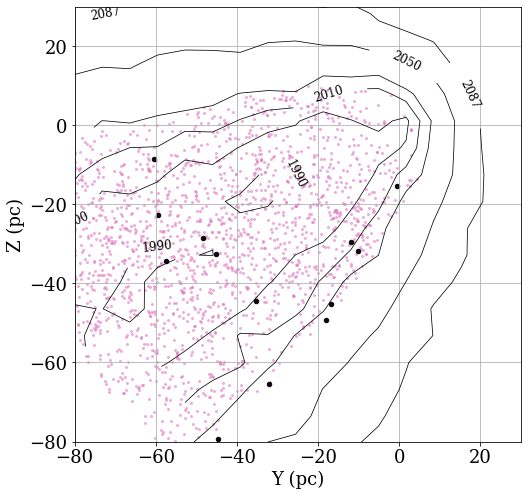

In [102]:
plt.figure(figsize=(8,8))

plt.scatter(GCNS['ycoord_50'][EYES], GCNS['zcoord_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['ycoord_50'][OYES], GCNS['zcoord_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=0.75, levels=[1990, 2000, 2010, 2020, 2050, 2087])
plt.clabel(cs, fontsize=12)

plt.xlim(-80, 30)
plt.ylim(-80, 30)
plt.grid(True)

Text(0, 0.5, 'Z (pc)')

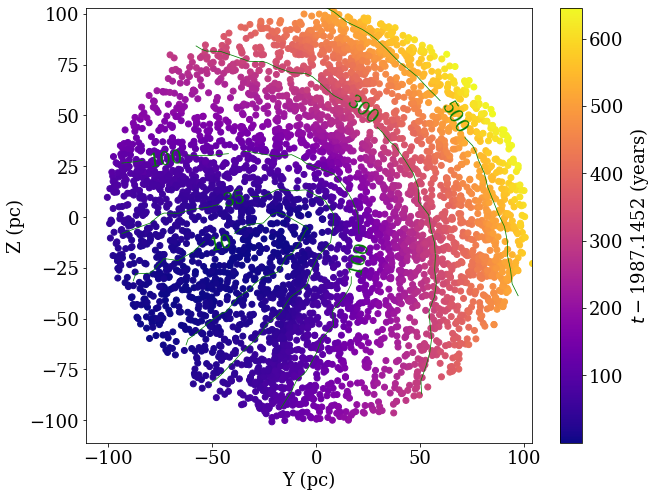

In [120]:
H, xe, ye, bn = binned_statistic_2d(GCNS['ycoord_50'][x10], GCNS['zcoord_50'][x10],
                                    values = etime[x10].value, statistic='mean', bins=30)
XX, YY = np.meshgrid(xe, ye)

plt.figure(figsize=(10,8))
plt.scatter(GCNS['ycoord_50'][x10], GCNS['zcoord_50'][x10],
            c=(etime[x10].value), cmap=plt.cm.plasma)
cb = plt.colorbar()
cb.set_label('$t - $'+format(t0.decimalyear, '7.4f') + ' (years)')

cs = plt.contour(xe[1:], ye[1:], H.T, colors='g', linewidths=0.75, levels=[10,35,100,300,500])
plt.clabel(cs, fontsize=18)


plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

In [133]:
# Which stars have crossed the ellipsoid since Gaia begain observing?
gstart = Time('2014.569312182902', format='decimalyear') # first Gaia alert
gstart1987 = (gstart-t0).to('year').value # years between first Gaia alert and date SN 1987A observed on Earth

e7 = ((etime.value >= gstart1987) & # since the first alert
      (etime.value < ((t1-t0).to('year').value+0.1)) # up to 0.1 years from now
     ) 
print('Variable stars that have crossed the ellipsoid since Gaia began observing: ' + str(sum(e7)))

Variable stars that have crossed the ellipsoid since Gaia began observing: 490


In [128]:
CE7 = SkyCoord(ra=GCNS['ra'][e7], dec=GCNS['dec'][e7], distance=GCNS['dist_50'][e7], frame = 'icrs')

Text(0, 0.5, 'Z (pc)')

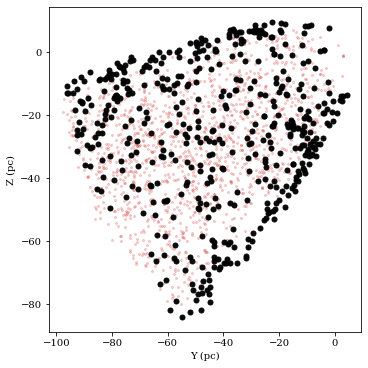

In [151]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()


ax.scatter(GCNS['ycoord_50'][EYES], GCNS['zcoord_50'][EYES], c='C3', s=4, alpha=0.2, rasterized=True)
ax.scatter(GCNS['ycoord_50'][e7], GCNS['zcoord_50'][e7], c='k', s=25, alpha=0.95, rasterized=True)

ax.set_xlabel('Y (pc)')
ax.set_ylabel('Z (pc)')

Text(0.5, 0, 'Z (pc)')

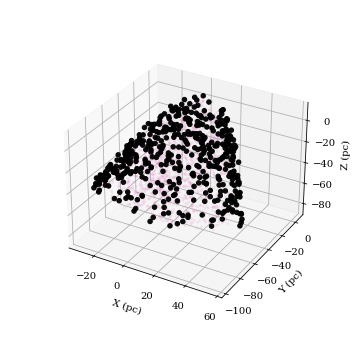

In [153]:
%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(GCNS['xcoord_50'][EYES], GCNS['ycoord_50'][EYES], GCNS['zcoord_50'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(GCNS['xcoord_50'][e7], GCNS['ycoord_50'][e7], GCNS['zcoord_50'][e7], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

# Black points are those that have crossed the ellipse since Gaia has been active

In [152]:
GCNS['source_id'][e7]

6548081373973468416
6537148826779472512
2379962604166006016
2395031273585836288
4986885500889922304
4999214840166796416
4986052376017997184
4987736729049009024
4987736729049009152
4984291478082944256
4960514951447008256
